# Lab 8: Graphical Models

# Work done by : Mohamed Amine HACHICHA

The goal of this lab session is to code two methods to estimate the structure of undirected gaussian graphical models and compare them.

You have to send the filled notebook named **"L8_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before December 12, 2019 at 23:59 and put **"AML-L8"** as subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Graphical Models

A graphical model is a probabilistic model for which a graph expresses the conditional dependence structure between random variables. The variables are represented by nodes and the relations between them are represented by edges.

### GLasso

Graphical Lasso is the name of the optimization problem that estimates the precision matrix of a multivariate gaussian and its name comes from the direct link with graphical models and the regularization term. 

Fill in the following class that implements the GLasso algorithm optimized by ADMM:

In [2]:
class my_GLasso():
    
    def __init__(self, alpha, mu, max_iter=200, tol=1e-5):
        '''
        Parameters:
        alpha : float
            Penalization parameter selected.
        mu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.alpha = alpha
        self.mu = mu
        self.max_iter_ = max_iter
        self.tol_ = tol
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        n, p = X.shape
        
        # Calculate the covariance matrix
        self.covariance_ = np.cov(np.transpose(X))
        
        # initialize Y
        Y = np.eye(p)

        # Initialize Z
        Z = np.eye(p)
        
        def soft_threshold(M, sigma):
            # Give the soft thresholding of matrix M regarding sigma
            A = M.copy()
            for i in range(A.shape[0]):
                for j in range(A.shape[1]):
                    if abs(A[i, j]) < sigma:
                        A[i, j] = 0
                    else:
                        A[i, j] = np.sign(A[i, j]) * (abs(A[i, j]) - sigma)
            return A
        
        S = self.covariance_
        itr = 0
        
        deviation = 1 
        self.precision_ = np.zeros(S.shape)
        while (itr<self.max_iter_) and (deviation>self.tol_):
            old_precision = self.precision_.copy()
            #   Update precision
            eigen_values, eigen_vectors = np.linalg.eig(Y - Z - S/self.mu)
            D = np.diag((eigen_values + np.sqrt(eigen_values**2 + 4/self.mu)))
            self.precision_ = 0.5 * np.dot(np.dot(eigen_vectors, D), eigen_vectors.T)
            
            #   Update Y
            Y = soft_threshold(M=self.precision_ + Z, sigma=self.alpha/self.mu)
            
            #   Update Z
            Z = Z + self.mu * (self.precision_ - Y)
            
            # Calculate deviation
            deviation = np.linalg.norm(old_precision - self.precision_, 2)
            
            itr += 1

Estimating the precision matrix from 60 samples... 



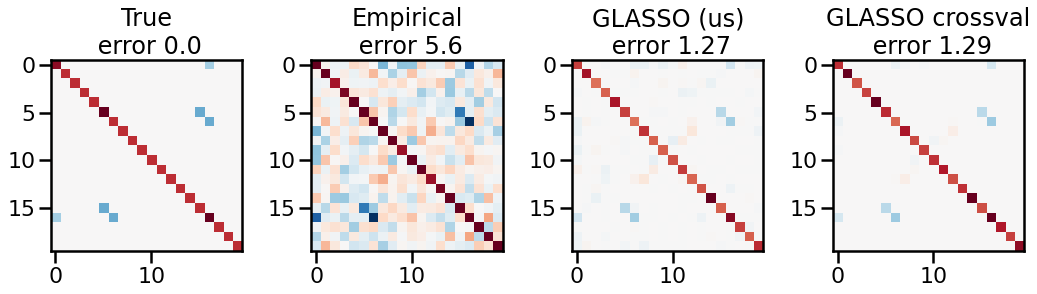

In [4]:
# Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

print(f'Estimating the precision matrix from {n_samples} samples... \n')


# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Graphical Lasso with cross validation 
from sklearn.covariance import GraphicalLassoCV
model = GraphicalLassoCV(cv=5)
model.fit(data)
prec_glassocv = model.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)

# Graphical Lasso estimation using our implementation
model = my_GLasso(alpha=0.15, mu=1)
model.fit(data)
prec_glasso = model.precision_
err_glasso = np.linalg.norm(prec - prec_glasso)
vmax = prec_glasso.max()


# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
fig.tight_layout()


Comment on the different methods' ability to recover the precision matrix structure and what that means in terms of the graph between features. 

#### The Empirical method fails to recover the precision matrix structure in low-sample regime (I tried the same experience with n=1000 observations and the empirical method gives significantly better results)

#### Our GLasso and sklearn's crossvalidated GLasso succeed to recover the global structure of the precision matrix : a sparse matrix with important values on the diagonal and some sparse connected components (blue dots). GLasso succeeds to recover these connected components.

#### We also notice that our GLasso has comparable results in terms of error with sklearn's GLasso !

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [5]:
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        
        Attributes:
        
        covariance_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.        
        '''
        self.graph_structure_ = None
        self.rule_ = rule
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        
        n, p = X.shape
        
        # betas[i, :] contains the coefficients of the Lasso regression of Xi as a function of Xj with j!=i
        betas = np.zeros((p, p))
        
        for j in range(p):
            y = X[:, j]
            x = X[:, np.array([True if i!=j else False for i in range(p)])]
            lasso_model = LassoCV(alphas=[0.1])
            lasso_model.fit(X=x, y=y)
            
            betas[j, np.array([True if i!=j else False for i in range(p)])] = lasso_model.coef_
        
        # Create the graph structure
        betas = np.absolute(betas) > 1e-4
        if self.rule_ == "OR":
            self.graph_structure_ = betas | betas.T
        
        elif self.rule_ == "AND":
            self.graph_structure_ = betas & betas.T

Generate an easy-to-check (non-trivial, p<=6) example and plot the 4 (real, GLasso, AND, OR) graphs. You can use `networkx` to plot the resulting graph.

In [23]:
# Simulate multivariate normal with mean mu and covariance cov

mu=[0, 1, 2, -1, 4]
cov = np.array([
    [2, 1, 1, 0, 0],
    [1, 2, 0, 0, 0],
    [1, 0, 2, 0, 1],
    [0, 0, 0, 2, 0],
    [0, 0, 1, 0, 2]
])

X = np.array([np.random.multivariate_normal(mu, cov) for i in range(1000)])
real_precision = np.linalg.inv(cov)

In [26]:
# Fit the 3 models

model_nreg_AND = my_nodewise_regression(rule='AND')
model_nreg_AND.fit(X)

model_nreg_OR = my_nodewise_regression(rule='OR')
model_nreg_OR.fit(X)

model_GLasso = my_GLasso(alpha=0.1, mu=1)
model_GLasso.fit(X)

# Construct the graph structure for the GLasso model
model_GLasso.graph_structure_ = np.abs(model_GLasso.precision_) > 1e-4
for i in range(X.shape[1]):
    model_GLasso.graph_structure_[i, i] = False

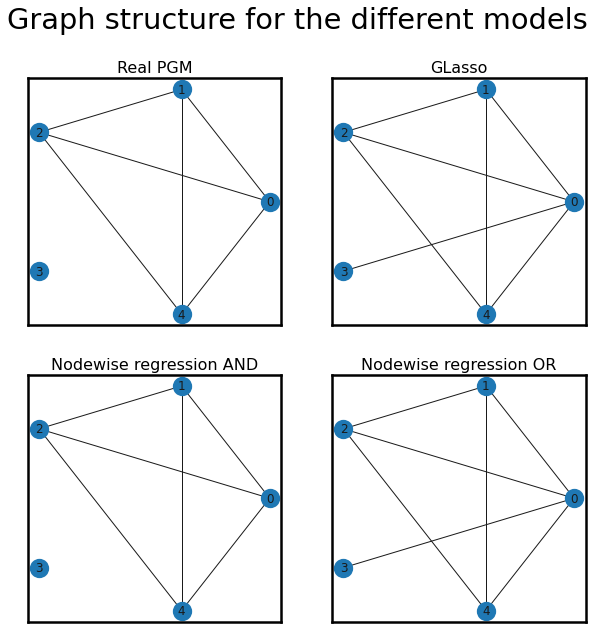

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph_structure(graph_structure):
    G = nx.from_numpy_matrix(graph_structure, create_using=nx.MultiGraph)
    layout = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, layout, alpha=1)
    nx.draw_networkx_edges(G, layout, alpha=1)
    nx.draw_networkx_labels(G, layout)

plt.figure(figsize=(10,10))
plt.suptitle('Graph structure for the different models')
plt.subplot(221)
draw_graph_structure(np.abs(real_precision) > 0)
plt.title("Real PGM", size=16)
plt.subplot(222)
draw_graph_structure(model_GLasso.graph_structure_)
plt.title("GLasso", size=16)
plt.subplot(223)
draw_graph_structure(model_nreg_AND.graph_structure_)
plt.title("Nodewise regression AND", size=16)
plt.subplot(224)
draw_graph_structure(model_nreg_OR.graph_structure_)
plt.title("Nodewise regression OR", size=16)

plt.show()

#### The True precision graph shows that components 0,1,2 and 4 are all fully connected and each one of them is insependent of component 3.
#### The AND - Nodewise Regression yields the perfect results. GLasso and OR-Nodewise Regression also give good results (but not perfect).

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 

In [28]:
def loglik_loss(model, X, alpha):
    precision = model.precision_
    det = np.linalg.det(precision)
    emp_cov = np.cov(X.T)
    return np.log(det) - np.trace(np.dot(emp_cov, model.precision_)) + alpha * np.linalg.norm(precision, 1)

In [29]:
from sklearn.metrics import f1_score, accuracy_score

def calculate_acc_f1(predicted_precision, real_precision):
    
    p = predicted_precision.shape[0]
    idx = [[j>i for j in range(p)] for i in range(p)]
    
    y_pred = np.absolute(predicted_precision[idx])
    y_true = np.absolute(real_precision[idx]) > 1e-5
    
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    return acc, f1

In [30]:
import scipy as sc
from sklearn.model_selection import KFold


def compare(mu, cov, precision, n_s):
    for n in n_s:
        print('########## Training with {} observations ##########'.format(n))
        X = np.array([np.random.multivariate_normal(mu, cov) for i in range(n)])
        alphas = [2**i for i in range(-5, 1)]
        
        print('--------- GLasso ----------')
        print('--- Selecting the best alpha ---')
        
        # I tried the K-Fold CV but it is very slow, you can remove the docstring commas """  """ to try it
        # I will use the CV GLasso of sklearn
        
        """n_splits = 3
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        loglik_losses = []
        for alpha in alphas:
            print(alpha)
            loss_alpha = 0
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                Glasso_model = my_GLasso(alpha=alpha, mu=1)
                Glasso_model.fit(X_train)
                print('fitted')
                loss_alpha += loglik_loss(model=Glasso_model, X=X_test, alpha=alpha)
            loss_alpha = loss_alpha / n_splits
            loglik_losses.append(loss_alpha)
        best_index = loglik_losses.index(min(loglik_losses))
        best_alpha = alphas[best_index]
        best_loss = loglik_losses[best_index]"""
        
        GLassoCV = GraphicalLassoCV(cv=3)
        GLassoCV.fit(X)        
        
        best_alpha = GLassoCV.alpha_
        best_loglik_loss = loglik_loss(model=GLassoCV, X=X, alpha=best_alpha)
        
        
        print('The best alpha is: {}'.format(GLassoCV.alpha_))
        print('The corresponding log-likelihood loss is: {}'.format(best_loglik_loss))
        
        print('--- Fitting the best Glasso model')
        
        GLasso_final = my_GLasso(alpha=best_alpha, mu=1)
        GLasso_final.fit(X)
        
        frob_loss = np.linalg.norm(GLasso_final.precision_ - precision, 2)
        print('**** The Frobenius loss is : {}'.format(frob_loss))
        
        print('--------- Nodewise Regression (AND) ----------')
        model_nreg_AND = my_nodewise_regression(rule='AND')
        model_nreg_AND.fit(X)
        acc, f1 = calculate_acc_f1(predicted_precision=model_nreg_AND.graph_structure_, real_precision=precision)
        print('*** F1 score : {}'.format(f1))
        print('*** Accuracy score : {}'.format(acc))


## AR(1)-Block model

In [31]:
block_size = 30

block = [[0.9**(abs(i - j)) for j in range(block_size)] for i in range(block_size)]
cov_AR = sc.linalg.block_diag(*[block for i in range(10)])
precision_AR = np.linalg.inv(cov_AR)

mu_AR = np.zeros(30*10)
n_s = [40, 80, 320]

compare(mu=mu_AR, cov=cov_AR, precision=precision_AR, n_s=n_s)

########## Training with 40 observations ##########
--------- GLasso ----------
--- Selecting the best alpha ---
The best alpha is: 0.345728381597126
The corresponding log-likelihood loss is: 16.00674765755595
--- Fitting the best Glasso model
**** The Frobenius loss is : 19.99731196422304
--------- Nodewise Regression (AND) ----------
*** F1 score : 0.7795698924731183
*** Accuracy score : 0.9963433667781494
########## Training with 80 observations ##########
--------- GLasso ----------
--- Selecting the best alpha ---
The best alpha is: 0.28227007906783336
The corresponding log-likelihood loss is: 36.19923763656235
--- Fitting the best Glasso model
**** The Frobenius loss is : 19.451312626496943
--------- Nodewise Regression (AND) ----------
*** F1 score : 0.9020217729393467
*** Accuracy score : 0.9985953177257525
########## Training with 320 observations ##########
--------- GLasso ----------
--- Selecting the best alpha ---
The best alpha is: 0.23510414880498615
The corresponding lo

## Exponential Decay model

In [32]:
cov_Exp = np.array([[np.exp(-2*abs(i-j)) for j in range(300)] for i in range(300)])
precision_Exp = np.linalg.inv(cov_Exp)

mu_Exp = np.zeros(30*10)
n_s = [40, 80, 320]

compare(mu=mu_Exp, cov=cov_Exp, precision=precision_Exp, n_s=n_s)

########## Training with 40 observations ##########
--------- GLasso ----------
--- Selecting the best alpha ---
The best alpha is: 0.672138831290229
The corresponding log-likelihood loss is: -288.8728906683078
--- Fitting the best Glasso model
**** The Frobenius loss is : 10.031822724110736
--------- Nodewise Regression (AND) ----------
*** F1 score : 0.037969459347915804
*** Accuracy score : 0.9480267558528428
########## Training with 80 observations ##########
--------- GLasso ----------
--- Selecting the best alpha ---
The best alpha is: 0.5169655862049349
The corresponding log-likelihood loss is: -300.1223486480676
--- Fitting the best Glasso model
**** The Frobenius loss is : 6.343479885058614
--------- Nodewise Regression (AND) ----------
*** F1 score : 0.04214854793112311
*** Accuracy score : 0.9169007803790412
########## Training with 320 observations ##########
--------- GLasso ----------
--- Selecting the best alpha ---
The best alpha is: 0.18251718944848516
The correspondin

*Comment and compare the methods and the effect of the sample size.*

#### I can't really compare the two methods (GLasso and Nodewise regression) results because we are using different evaluation metrics, but I noticed that Nodewise regression was faster

#### For GLasso, we notice that for both models the Frobenius norm loss decreases when the number of observations increases, which is logical as we have more information about the relationships between the variables.

#### For Nodewise regression, we notice that we always have a good accuracy. Accuracy is, in this case, a misleading metric because of the sparsity of the precision matrices after binary thresholding : there's a big imbalance in labels population.

#### F1 score is more accurate. And we see here that the F1 score also increases when the number of observation increases for both models which is also logical.

#### We also notice that for the first model, we get a good F1 score even with a low number of observations and this is due to the sparsity of the covariance matrix and its' remarkable structure (block diagonal).

#### For the second model, and with a non sparse covariance matrix, we get a very low F1 score when the number of observations is low, even though the covariance matrix has the majority of its' cells values close to 0 due to the exponential decay. This F1 score tends to increase when the number of observation increases and it seems that 320 observations are always not enough to yield a good score.